In [1]:
from PIL import Image
import numpy as np
import os, shutil
from os.path import split, splitext, exists, join
from glob import glob
from tqdm import tqdm
from configs import cfg

In [2]:
Output_path = cfg.Output_path

input_dataset = os.path.join(Output_path, "clean")
output_dataset = os.path.join(Output_path, "mask")
print(input_dataset)
print(output_dataset)
print(Output_path)

../../dataset/pseudo_images/cabinet_picture_with_white_bg/clean
../../dataset/pseudo_images/cabinet_picture_with_white_bg/mask
../../dataset/pseudo_images/cabinet_picture_with_white_bg


In [3]:
if exists(output_dataset):
    shutil.rmtree(output_dataset)
os.mkdir(output_dataset)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 53.48it/s]


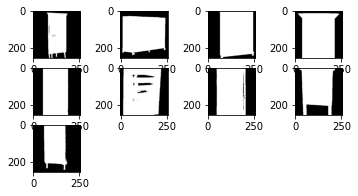

In [6]:
import matplotlib.pyplot as plt
j = 1

rgb_files = glob(join(input_dataset, '*.jpg'))
for rgb_file in tqdm(rgb_files):
    #print(j)
    fn = splitext(split(rgb_file)[-1])[0]
    img = Image.open(rgb_file)
    img = np.array(img)
    mask = 255 * np.ones_like(img)
    bg = np.nonzero(1 - np.prod(img <= 240, axis=-1))
    mask[bg] = 0
    mask = Image.fromarray(mask)
    plt.subplot(4,4,j)
    plt.imshow(mask)
    j += 1
    mask.save(join(output_dataset, fn + '.jpg'), quality=95)

In [7]:
Output_path = cfg.Output_path
Radius = cfg.blur_radius
Nsample = cfg.blur_samples

input_dataset = os.path.join(Output_path, "mask")
output_dataset = os.path.join(Output_path, f"processed_mask_r{Radius}_nsample{Nsample}")
if os.path.exists(output_dataset):
    shutil.rmtree(output_dataset)
os.mkdir(output_dataset)

In [8]:
print(input_dataset)
print(output_dataset)
print(Output_path)

../../dataset/pseudo_images/cabinet_picture_with_white_bg/mask
../../dataset/pseudo_images/cabinet_picture_with_white_bg/processed_mask_r1_nsample20
../../dataset/pseudo_images/cabinet_picture_with_white_bg


In [10]:
Batch_size = 64

files = glob(os.path.join(input_dataset, "*.jpg"))

In [14]:
import torch

OSError: libmkl_intel_lp64.so: cannot open shared object file: No such file or directory

In [ ]:
images = np.stack([np.array(Image.open(fn)) for fn in tqdm(files)])
images[images < 127] = 0
images[images >= 128] = 255
images = torch.from_numpy(images).cuda()
start = time()
masks = []
for i in trange(len(images) // Batch_size + 1):
    batch = images[i * Batch_size: min((i+1) * Batch_size, len(images))]
    masks.append(Pixel2Mask(radius=Radius, nsample=Nsample)(batch, 256))